In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [51]:
import fastai
from fastai import *
from fastai.text import *
from functools import partial
import io
import seaborn as sns



In [52]:
# READ THE TRAINING DATASET
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,Police investigating after an e-bike collided ...,1


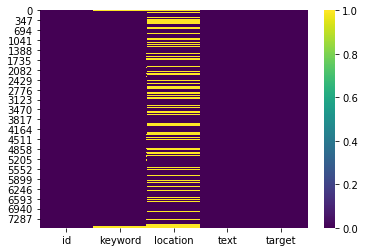

In [54]:
train_data.isnull()
sns.heatmap(train_data.isnull(), cmap='viridis')

# Many unknowns in the location column. 
# For the moment, we are not going to use it
train_data = train_data.drop(columns = ['id','location'])
train_data

In [55]:
# REPEATED KEYWORDS
print(f"Total keywords in the training set: {train_data.keyword.nunique()}")
train_data.keyword.value_counts().head(15)

Total keywords in the training set: 221


fatalities     45
deluge         42
armageddon     42
damage         41
sinking        41
harm           41
body%20bags    41
outbreak       40
collided       40
evacuate       40
windstorm      40
fear           40
siren          40
twister        40
earthquake     39
Name: keyword, dtype: int64

In [56]:
# PERCENTAGE OF REAL DISASTERS WITH EACH KEYWORD
word_probability = train_data.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'counts', 'target':'disaster_probability'}).sort_values('disaster_probability').tail(15)
word_probability

,counts,disaster_probability
keyword,,
wildfire,33,0.878788
razed,35,0.885714
evacuated,36,0.888889
nuclear%20disaster,34,0.911765
rescuers,35,0.914286
suicide%20bomb,35,0.914286
bombing,29,0.931034
suicide%20bomber,31,0.967742
suicide%20bombing,33,0.969697


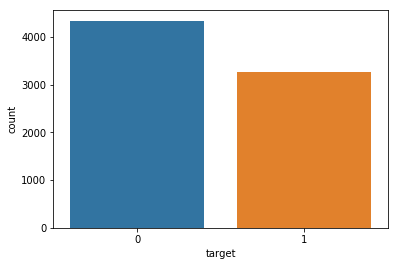

In [57]:
sns.countplot(x='target', data=train_data)

In [58]:
# SOURCE: https://medium.com/datadriveninvestor/identifying-disaster-related-tweets-using-deep-learning-and-natural-language-processing-with-fast-e0dfb790b57a
# GETTING THE DATA READY FOR MODELLING
# When working with text, we change the raw text to a list of words or tokens: TOKENIZATION
# Then, transform those tokens into numbers: NUMERICALIZATION
# The numbers are passed to embedding layers that will convert them into arrays of floats
# These arrays are fed to the model
train_data = train_data.drop(columns = ['keyword'])

In [59]:
# WE DON'T FOLLOW THE PREVIOUS LINK
# DATA PREPROCESSING
# Retain only alphabets
train_data['text'] = train_data['text'].str.replace("[^a-zA-Z]", " ")
train_data

,text,target
0,Our Deeds are the Reason of this earthquake M...,1
1,Forest fire near La Ronge Sask Canada,1
2,All residents asked to shelter in place are ...,1
3,people receive wildfires evacuation or...,1
4,Just got sent this photo from Ruby Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,aria ahrary TheTawniest The out of control w...,1
7610,M UTC km S of Volcano Hawaii htt...,1
7611,Police investigating after an e bike collided ...,1


In [60]:
# Get rid of stopwords
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

#Tokenization
tokenized_doc = train_data['text'].apply(lambda x: x.split())
tokenized_doc

0       [Our, Deeds, are, the, Reason, of, this, earth...
1           [Forest, fire, near, La, Ronge, Sask, Canada]
2       [All, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [Just, got, sent, this, photo, from, Ruby, Ala...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [aria, ahrary, TheTawniest, The, out, of, cont...
7610    [M, UTC, km, S, of, Volcano, Hawaii, http, t, ...
7611    [Police, investigating, after, an, e, bike, co...
7612    [The, Latest, More, Homes, Razed, by, Northern...
Name: text, Length: 7613, dtype: object

In [61]:
# Remove stop words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc

0       [Our, Deeds, Reason, earthquake, May, ALLAH, F...
1           [Forest, fire, near, La, Ronge, Sask, Canada]
2       [All, residents, asked, shelter, place, notifi...
3       [people, receive, wildfires, evacuation, order...
4       [Just, got, sent, photo, Ruby, Alaska, smoke, ...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [aria, ahrary, TheTawniest, The, control, wild...
7610    [M, UTC, km, S, Volcano, Hawaii, http, co, zDt...
7611    [Police, investigating, e, bike, collided, car...
7612    [The, Latest, More, Homes, Razed, Northern, Ca...
Name: text, Length: 7613, dtype: object

In [62]:
# De-tokenization
detokenized_doc = []
for i in range(len(train_data)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
train_data['text'] = detokenized_doc
train_data

,text,target
0,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,Forest fire near La Ronge Sask Canada,1
2,All residents asked shelter place notified off...,1
3,people receive wildfires evacuation orders Cal...,1
4,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...
7608,Two giant cranes holding bridge collapse nearb...,1
7609,aria ahrary TheTawniest The control wild fires...,1
7610,M UTC km S Volcano Hawaii http co zDtoyd EbJ,1
7611,Police investigating e bike collided car Littl...,1


In [63]:
# SPLIT THE DATASET INTO TRAINING(60%) AND VALIDATION(40%) SETS
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(train_data, stratify = train_data['target'], test_size=0.4, random_state=12)

In [64]:
# PREPARE THE DATA FOR THE LANGUAGE MODEL USING TORCH AND FASTAI LIBRARIES
data_lm = TextLMDataBunch.from_df(train_df=train_data, valid_df=valid_data, path="") # It gives errors if there are NaN values
# BE CAREFUL! WE HAVE TO SPLIT TRAIN_DATA INTO TRAIN_DATA AND VALID_DATA
# WE CAN NOT USE TEST_DATA AS VALID_DATA BECAUSE WE DON'T HAVE COLUMN TARGET
data_lm

TextLMDataBunch;

Train: LabelList (4567 items)
x: LMTextList
xxbos 0,xxbos 1,xxbos 1,xxbos 0,xxbos 1
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (3046 items)
x: LMTextList
xxbos 0,xxbos 1,xxbos 1,xxbos 1,xxbos 0
y: LMLabelList
,,,,
Path: .;

Test: None

In [65]:
# DATA FOR THE CLASSIFIER MODEL DATA
data_clas = TextClasDataBunch.from_df(path=" ", train_df = train_data, valid_df = valid_data, vocab = data_lm.train_ds.vocab, bs=32)
#PROBLEMS HERE


/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Some drugs alcohol Jackson Vroman house http co OQhQ QUQV, Sinking Slipper Putting Boot In http co b bx ERuep, TIX Frozen Fury XVII Los Angeles Kings v Avalanche Row AA MGM Grand http co kBtZZZG Tp, Given US coalition fondness backing style totalitarianism surprise copied http co wvChg M, Japan Restart Nuclear Reactor Fleet Fast Approaches http co DbAUjp Ub...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [66]:
# LEARNER OBJECT
learn = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True,  
                               drop_mult=0.7)

In [67]:
# Train the learner object with learning rate 1e-2
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,6.073361,4.819894,0.177902,00:00


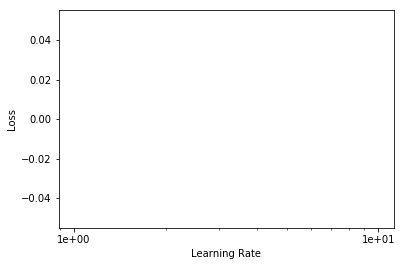

In [68]:
learn.recorder.plot()

In [69]:
# Save this encoder to use it for classification later
learn.save_encoder('ft_enc')

In [70]:
# Data_clas object to build a classifier with our fine-Tuned encoder
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4567 items)
x: TextList
xxbos 0,xxbos 1,xxbos 1,xxbos 0,xxbos 1
y: CategoryList
A new favorite Midfield General Disco Sirens House Edm Version Soni Soner sonisoner https co DEvffPTCVj SoundCloud,West Nyack Pineview Road railroad crossing Western Highway Units scene CSX Train vs truck injuries,Plains All American Pipeline company may spilled crude oil previously estimated KSBYNews lilitan http co PegibIqk w,Cascada Evacuate The Dancefloor Official Video https co OHCx l via YouTube,M SETTLEMENT attained using illustrations help jurors understand true devastation internal injuries http co BaXg WdPP
Path:  ;

Valid: LabelList (58 items)
x: TextList
xxbos 1,xxbos 0,xxbos 0,xxbos 1,xxbos 0
y: CategoryList
Mmmmmm I burning I burning buildings I building Oooooohhhh oooh ooh,He came land engulfed tribal war turned land peace e Madinah ProphetMuhammad islam,He came land engulfed tribal war turned land peace e Madinah ProphetMuhammad islam,Yea

In [71]:
data_clas.show_batch()

text,target
xxbos 1,Stop Annihilation Salt River Wild Horses http co wVobVVtXKg via Change
xxbos 0,biggest fear eventually see way see
xxbos 1,MH victim family furious media told wreckage confirmation first http co carMqiVkwU
xxbos 0,RebeccaforReal accepts Wisconsin Emergency Response Plan behalf GovWalker nbc http co Pis aiVRbR
xxbos 1,Skinny Jeans Hazardous Your Health socialnews http co Pk HujD


epoch,train_loss,valid_loss,accuracy,time
0,8.806889,8.170872,0.000000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,8.623434,8.258877,0.000000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,8.524065,8.201395,0.000000,00:02


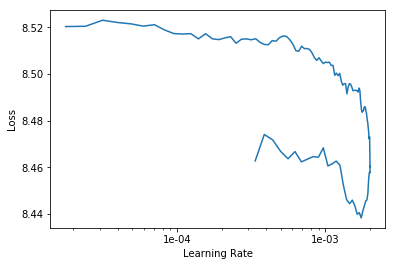

In [72]:
# Fit again the model
learn.fit_one_cycle(1, 1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))
learn.recorder.plot()

In [73]:
# Predictions for the validation set
preds, targets = learn.get_preds() 
predictions = np.argmax(preds, axis = 1)

In [74]:
pd.crosstab(predictions, targets)

col_0,291,292,293,294,309,406,469,901,1021,1133,...,3795,3830,3940,3951,3963,4018,4196,4369,4388,4414
row_0,,,,,,,,,,,,,,,,,,,,,
849,2,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,2,1,0,1,1
2431,0,1,2,2,2,1,1,1,1,3,...,1,1,1,0,1,1,0,1,0,0


In [ ]:
# it doesn't work. It is giving problems in the data_clas